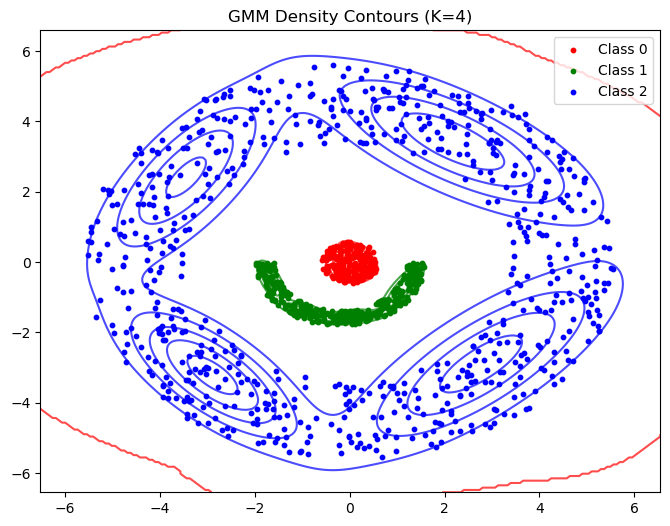

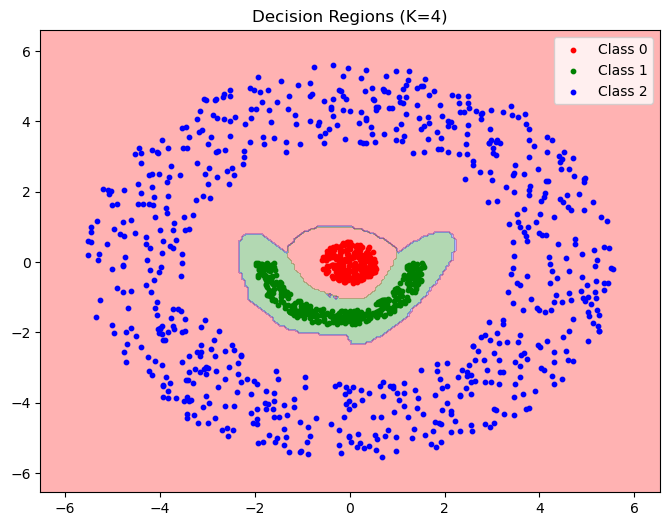

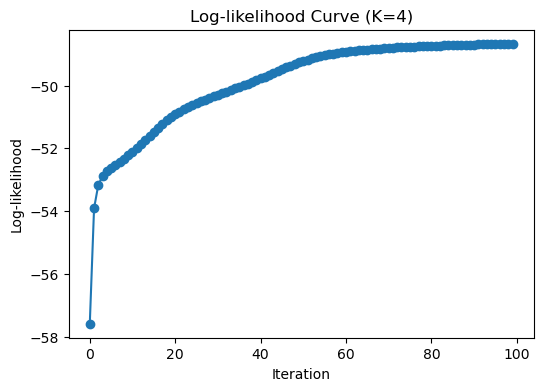

Running Dataset1_NLS with 1 mixtures...
Accuracy: 0.9981, Mean F1: 0.9983
Running Dataset1_NLS with 2 mixtures...
Accuracy: 1.0000, Mean F1: 1.0000
Running Dataset1_NLS with 4 mixtures...
Accuracy: 1.0000, Mean F1: 1.0000


In [4]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

# ========== Utility Functions ==========
def save_npy(obj, path):
    np.save(path, obj)

def load_npy(path):
    return np.load(path, allow_pickle=True)

def save_json(obj, path):
    with open(path, 'w') as f:
        json.dump(obj, f)

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# ========== Data Loading ==========
def load_txt_data(base_path, class_names):
    train, test = [], []
    for cls in class_names:
        train.append(np.loadtxt(os.path.join(base_path, 'train', f'{cls}_train.txt')))
        test.append(np.loadtxt(os.path.join(base_path, 'test', f'{cls}_test.txt')))
    return train, test

# ========== K-means ==========
def kmeans(X, K, max_iter=100, tol=1e-4):
    np.random.seed(42)
    N, D = X.shape
    centroids = X[np.random.choice(N, K, replace=False)]
    for it in range(max_iter):
        # Assignment step
        dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(dists, axis=1)
        # Update step
        new_centroids = np.array([X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k] for k in range(K)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels

# ========== GMM (EM Algorithm) ==========
def gmm_em(X, K, max_iter=100, tol=1e-4):
    N, D = X.shape
    # K-means initialization
    means, labels = kmeans(X, K)
    covs = np.array([np.cov(X[labels == k].T) + 1e-6*np.eye(D) if np.any(labels == k) else np.eye(D) for k in range(K)])
    weights = np.array([np.mean(labels == k) for k in range(K)])
    log_likelihoods = []
    for it in range(max_iter):
        # E-step: responsibilities
        resp = np.zeros((N, K))
        for k in range(K):
            resp[:, k] = weights[k] * gaussian_pdf(X, means[k], covs[k])
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp = resp / (resp_sum + 1e-10)
        # M-step
        Nk = resp.sum(axis=0)
        weights = Nk / N
        means = np.array([np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k] for k in range(K)])
        covs = np.array([
            ((resp[:, k][:, None] * (X - means[k])).T @ (X - means[k])) / Nk[k] + 1e-6*np.eye(D)
            for k in range(K)
        ])
        # Log-likelihood
        ll = np.sum(np.log(resp_sum + 1e-10))
        log_likelihoods.append(ll)
        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    params = {'means': means, 'covs': covs, 'weights': weights}
    return params, log_likelihoods

def gaussian_pdf(X, mean, cov):
    D = X.shape[1]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi), D/2) * np.sqrt(cov_det + 1e-10))
    diff = X - mean
    exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    return norm_const * exp_term

# ========== Bayes Classifier ==========
def bayes_classifier(X, gmm_params_list):
    N = X.shape[0]
    num_classes = len(gmm_params_list)
    scores = np.zeros((N, num_classes))
    for c, params in enumerate(gmm_params_list):
        K = len(params['weights'])
        prob = np.zeros((N, K))
        for k in range(K):
            prob[:, k] = params['weights'][k] * gaussian_pdf(X, params['means'][k], params['covs'][k])
        scores[:, c] = prob.sum(axis=1)
    preds = np.argmax(scores, axis=1)
    return preds

# ========== Metrics ==========
def compute_metrics(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    acc = np.trace(cm) / np.sum(cm)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        precision[i] = tp / (tp + fp + 1e-10)
        recall[i] = tp / (tp + fn + 1e-10)
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i] + 1e-10)
    metrics = {
        'accuracy': acc,
        'precision': precision.tolist(),
        'mean_precision': np.mean(precision),
        'recall': recall.tolist(),
        'mean_recall': np.mean(recall),
        'f1': f1.tolist(),
        'mean_f1': np.mean(f1),
        'confusion_matrix': cm.tolist()
    }
    return metrics

# ========== Experiment Runner ==========
def run_experiment(dataset_name, train_data, test_data, mixture_counts, result_dir):
    ensure_dir(result_dir)
    num_classes = len(train_data)
    for K in mixture_counts:
        print(f'Running {dataset_name} with {K} mixtures...')
        # Fit GMM for each class
        gmm_params_list = []
        log_likelihoods_list = []
        for i, cls_data in enumerate(train_data):
            params, log_likelihoods = gmm_em(cls_data, K)
            gmm_params_list.append(params)
            log_likelihoods_list.append(log_likelihoods)
            save_npy(params, f'{result_dir}/gmm_params_class{i}_K{K}.npy')
            save_npy(log_likelihoods, f'{result_dir}/gmm_loglik_class{i}_K{K}.npy')
        # Bayes classifier
        y_true = []
        X_test = []
        for i, cls_test in enumerate(test_data):
            y_true.extend([i]*len(cls_test))
            X_test.append(cls_test)
        X_test = np.vstack(X_test)
        y_true = np.array(y_true)
        y_pred = bayes_classifier(X_test, gmm_params_list)
        save_npy(y_true, f'{result_dir}/y_true_K{K}.npy')
        save_npy(y_pred, f'{result_dir}/y_pred_K{K}.npy')
        # Metrics
        metrics = compute_metrics(y_true, y_pred, num_classes)
        save_json(metrics, f'{result_dir}/metrics_K{K}.json')
        print(f'Accuracy: {metrics["accuracy"]:.4f}, Mean F1: {metrics["mean_f1"]:.4f}')

# ========== Visualization Functions ==========

# ---------- Contour Plot for GMM ----------
def plot_gmm_contours_with_decision_separate(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10,8))
    # Plot training data
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    # Grid for contours and decision regions
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 300)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 300)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    # Decision regions
    preds = bayes_classifier(grid, gmm_params_list)
    Z = preds.reshape(X.shape)
    plt.contourf(X, Y, Z, alpha=0.15, levels=len(gmm_params_list), colors=colors)
    # GMM contours for each class (separate)
    for i, params in enumerate(gmm_params_list):
        Zc = np.zeros(X.shape)
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            weight = params['weights'][k]
            pdf_vals = weight * gaussian_pdf(grid, mean, cov)
            Zc += pdf_vals.reshape(X.shape)
        plt.contour(X, Y, Zc, levels=5, colors=colors[i], alpha=0.9, linewidths=2, linestyles='solid', label=f'GMM Class {i}')
    plt.legend()
    plt.title(f'Separate GMM Contours and Decision Boundaries (K={K})')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage:


def plot_gmm_contours(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(8,6))
    # Plot training data
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    # Plot GMM contours
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 200)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 200)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    for i, params in enumerate(gmm_params_list):
        Z = np.zeros(X.shape)
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            weight = params['weights'][k]
            rv = np.random.multivariate_normal(mean, cov, 1) # just for shape
            # Use your gaussian_pdf for grid
            grid = pos.reshape(-1,2)
            pdf_vals = weight * gaussian_pdf(grid, mean, cov)
            Z += pdf_vals.reshape(X.shape)
        plt.contour(X, Y, Z, levels=5, colors=colors[i], alpha=0.7)
    plt.legend()
    plt.title(f'GMM Density Contours (K={K})')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ---------- Decision Region Plot ----------
def plot_decision_regions(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 200)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = bayes_classifier(grid, gmm_params_list)
    Z = preds.reshape(X.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(X, Y, Z, alpha=0.3, levels=len(gmm_params_list), colors=colors)
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    plt.title(f'Decision Regions (K={K})')
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ---------- Log-likelihood Curve ----------
def plot_log_likelihood(log_likelihoods, K, save_path=None):
    plt.figure(figsize=(6,4))
    plt.plot(log_likelihoods, marker='o')
    plt.title(f'Log-likelihood Curve (K={K})')
    plt.xlabel('Iteration')
    plt.ylabel('Log-likelihood')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ---------- Example Usage ----------
# Load results for a given K
K = 4
result_dir = 'results/Dataset1_NLS'
train1, _ = load_txt_data(
    r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\NLS_Group04',
    ['class1', 'class2', 'class3']
)
gmm_params_list = [load_npy(f'{result_dir}/gmm_params_class{i}_K{K}.npy').item() for i in range(3)]
log_likelihoods = load_npy(f'{result_dir}/gmm_loglik_class0_K{K}.npy')

plot_gmm_contours(train1, gmm_params_list, K, save_path=f'{result_dir}/gmm_contours_K{K}.png')
plot_decision_regions(train1, gmm_params_list, K, save_path=f'{result_dir}/decision_regions_K{K}.png')
plot_log_likelihood(log_likelihoods, K, save_path=f'{result_dir}/loglik_K{K}.png')

# ========== Main ==========
# Dataset 1: NLS
train1, test1 = load_txt_data(
    r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\NLS_Group04',
    ['class1', 'class2', 'class3']
)
run_experiment('Dataset1_NLS', train1, test1, [1,2,4], 'results/Dataset1_NLS')

# # Dataset 2a: Speech
# train2a, test2a = load_txt_data(
#     r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\rd_group4',
#     ['class1', 'class2', 'class3']
# )
# run_experiment('Dataset2a_Speech', train2a, test2a, [1,2,4,8,16,32,64], 'results/Dataset2a_Speech')

# For Dataset 2b and 2c, add image feature extraction and clustering code as needed.

In [3]:
import numpy as np
import json

def print_metrics(metrics):
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Precision per class:", ["{:.4f}".format(p) for p in metrics['precision']])
    print("Mean Precision:", "{:.4f}".format(metrics['mean_precision']))
    print("Recall per class:", ["{:.4f}".format(r) for r in metrics['recall']])
    print("Mean Recall:", "{:.4f}".format(metrics['mean_recall']))
    print("F1 per class:", ["{:.4f}".format(f) for f in metrics['f1']])
    print("Mean F1:", "{:.4f}".format(metrics['mean_f1']))
    print("Confusion Matrix:")
    print(np.array(metrics['confusion_matrix']))

# Example: Load metrics for best K (e.g., K=4)
K = 4
result_dir = 'results/Dataset1_NLS'
metrics_path = f'{result_dir}/metrics_K{K}.json'

with open(metrics_path, 'r') as f:
    metrics = json.load(f)

print_metrics(metrics)

Accuracy: 1.0000
Precision per class: ['1.0000', '1.0000', '1.0000']
Mean Precision: 1.0000
Recall per class: ['1.0000', '1.0000', '1.0000']
Mean Recall: 1.0000
F1 per class: ['1.0000', '1.0000', '1.0000']
Mean F1: 1.0000
Confusion Matrix:
[[ 90   0   0]
 [  0 150   0]
 [  0   0 300]]


C:\Users\Pratik Manusmare\AppData\Local\Temp\ipykernel_5224\1031260806.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Zc, levels=levels, colors=colors[i], alpha=0.9, linewidths=2, linestyles='solid', label=f'GMM Class {i}')


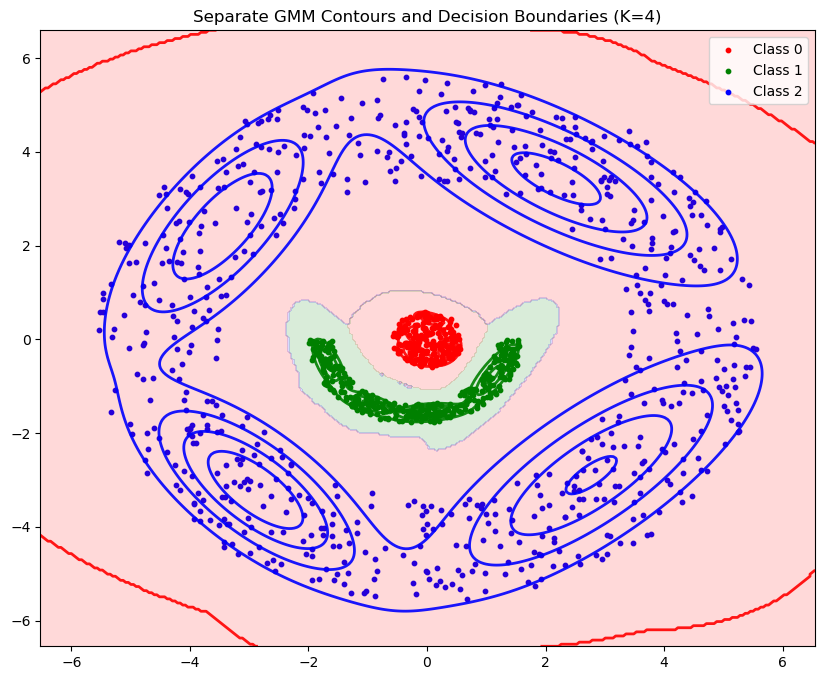

In [7]:
def plot_gmm_contours_with_decision_separate(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10,8))
    # Plot training data
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    # Grid for contours and decision regions
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 300)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 300)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    # Decision regions
    preds = bayes_classifier(grid, gmm_params_list)
    Z = preds.reshape(X.shape)
    plt.contourf(X, Y, Z, alpha=0.15, levels=len(gmm_params_list), colors=colors)
    # GMM contours for each class (separate, with unique levels)
    for i, params in enumerate(gmm_params_list):
        Zc = np.zeros(X.shape)
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            weight = params['weights'][k]
            pdf_vals = weight * gaussian_pdf(grid, mean, cov)
            Zc += pdf_vals.reshape(X.shape)
        # Use unique levels for each class to avoid merging
        levels = np.linspace(Zc.min(), Zc.max(), 6)
        plt.contour(X, Y, Zc, levels=levels, colors=colors[i], alpha=0.9, linewidths=2, linestyles='solid', label=f'GMM Class {i}')
    plt.legend()
    plt.title(f'Separate GMM Contours and Decision Boundaries (K={K})')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage:
K = 4
result_dir = 'results/Dataset1_NLS'
train1, _ = load_txt_data(
    r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\NLS_Group04',
    ['class1', 'class2', 'class3']
)
gmm_params_list = [load_npy(f'{result_dir}/gmm_params_class{i}_K{K}.npy').item() for i in range(3)]
plot_gmm_contours_with_decision_separate(train1, gmm_params_list, K, save_path=f'{result_dir}/gmm_contours_decision_separate_K{K}.png')

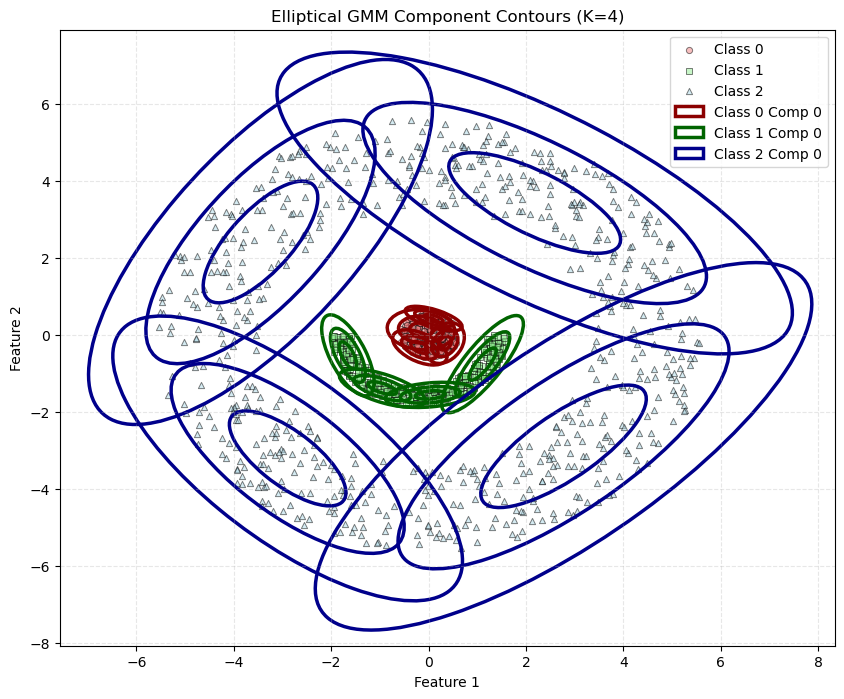

In [18]:
def plot_gmm_elliptical_contours(train_data, gmm_params_list, K, save_path=None):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse

    # Faint colors for data points, dark colors for contours
    point_colors = ['lightcoral', 'lightgreen', 'lightblue']
    contour_colors = ['darkred', 'darkgreen', 'darkblue']
    markers = ['o', 's', '^']
    plt.figure(figsize=(10,8))
    # Plot training data with faint colors and black thin border
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=20, color=point_colors[i], marker=markers[i],
                    label=f'Class {i}', alpha=0.5, edgecolor='black', linewidths=0.7)
    # Plot 3 dark ellipses (1σ, 2σ, 3σ) for each Gaussian component
    for i, params in enumerate(gmm_params_list):
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:,order]
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            for n_sigma in [1, 2, 3]:
                edgecolor = contour_colors[i]
                ellip = Ellipse(xy=mean, width=2*n_sigma*np.sqrt(vals[0]), height=2*n_sigma*np.sqrt(vals[1]),
                                angle=theta, edgecolor=edgecolor, fc='None', lw=2.5, alpha=1.0,
                                label=f'Class {i} Comp {k}' if (n_sigma==1 and k==0) else None)
                plt.gca().add_patch(ellip)
    plt.legend()
    plt.title(f'Elliptical GMM Component Contours (K={K})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    if save_path:
        plt.savefig(save_path)
    plt.show()
# Example usage:
K = 4
result_dir = 'results/Dataset1_NLS'
train1, _ = load_txt_data(
    r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\NLS_Group04',
    ['class1', 'class2', 'class3']
)
gmm_params_list = [load_npy(f'{result_dir}/gmm_params_class{i}_K{K}.npy').item() for i in range(3)]
plot_gmm_elliptical_contours(train1, gmm_params_list, K, save_path=f'{result_dir}/gmm_elliptical_contours_K{K}.png')

Running Dataset1_NLS with 1 mixtures...
Accuracy: 0.9981, Mean F1: 0.9983
Running Dataset1_NLS with 2 mixtures...
Accuracy: 1.0000, Mean F1: 1.0000
Running Dataset1_NLS with 4 mixtures...
Accuracy: 1.0000, Mean F1: 1.0000
Running Dataset1_NLS with 8 mixtures...
Accuracy: 1.0000, Mean F1: 1.0000


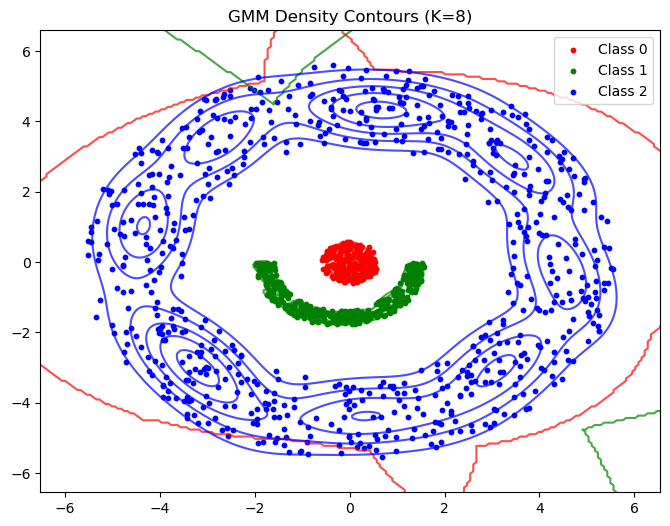

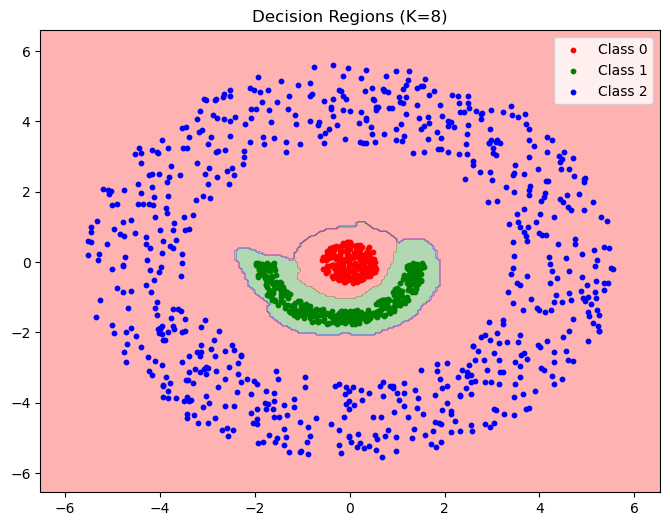

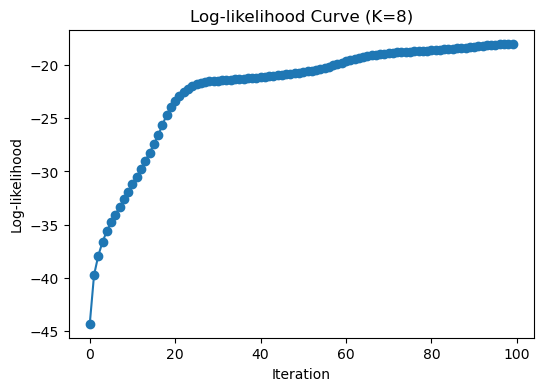

C:\Users\Pratik Manusmare\AppData\Local\Temp\ipykernel_5224\2022378541.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Zc, levels=levels, colors=colors[i], alpha=0.9, linewidths=2, linestyles='solid', label=f'GMM Class {i}')


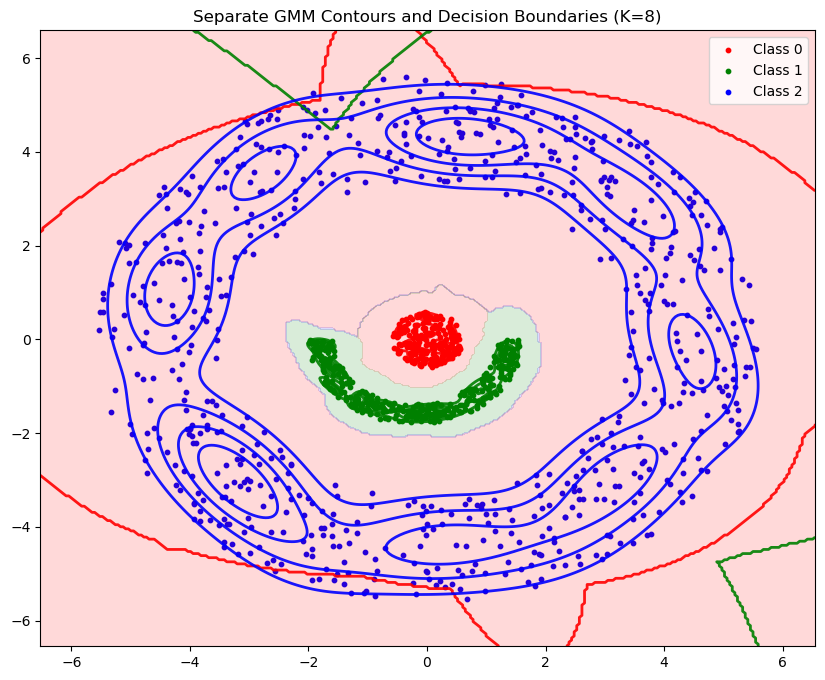

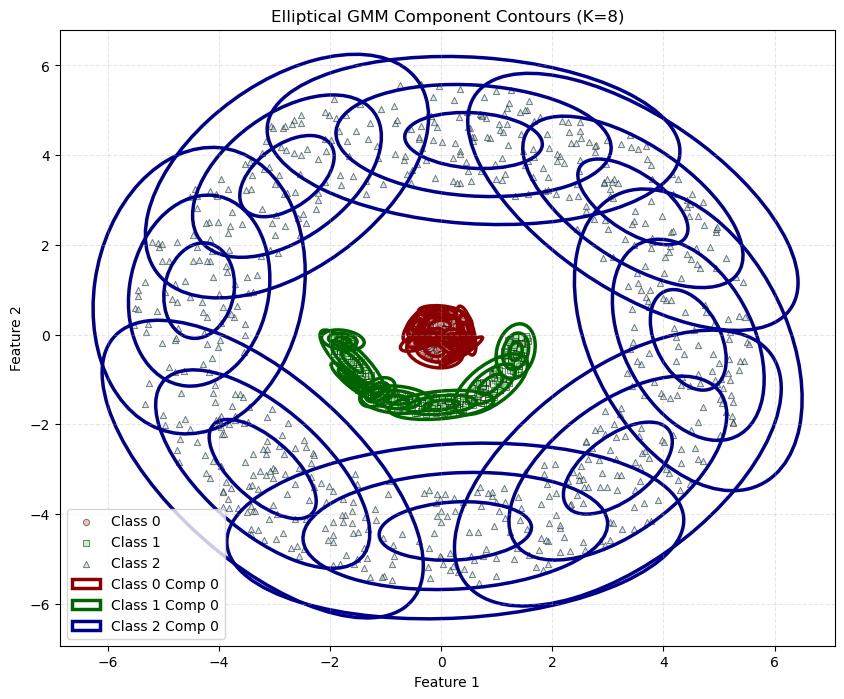

Accuracy: 1.0000
Precision per class: ['1.0000', '1.0000', '1.0000']
Mean Precision: 1.0000
Recall per class: ['1.0000', '1.0000', '1.0000']
Mean Recall: 1.0000
F1 per class: ['1.0000', '1.0000', '1.0000']
Mean F1: 1.0000
Confusion Matrix:
[[ 90   0   0]
 [  0 150   0]
 [  0   0 300]]


In [21]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# ========== Utility Functions ==========
def save_npy(obj, path):
    np.save(path, obj)

def load_npy(path):
    return np.load(path, allow_pickle=True)

def save_json(obj, path):
    with open(path, 'w') as f:
        json.dump(obj, f)

def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# ========== Data Loading ==========
def load_txt_data(base_path, class_names):
    train, test = [], []
    for cls in class_names:
        train.append(np.loadtxt(os.path.join(base_path, 'train', f'{cls}_train.txt')))
        test.append(np.loadtxt(os.path.join(base_path, 'test', f'{cls}_test.txt')))
    return train, test

# ========== K-means ==========
def kmeans(X, K, max_iter=100, tol=1e-4):
    np.random.seed(42)
    N, D = X.shape
    centroids = X[np.random.choice(N, K, replace=False)]
    for it in range(max_iter):
        dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(dists, axis=1)
        new_centroids = np.array([X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k] for k in range(K)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels

# ========== GMM (EM Algorithm) ==========
def gaussian_pdf(X, mean, cov):
    D = X.shape[1]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi), D/2) * np.sqrt(cov_det + 1e-10))
    diff = X - mean
    exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    return norm_const * exp_term

def gmm_em(X, K, max_iter=100, tol=1e-4):
    N, D = X.shape
    means, labels = kmeans(X, K)
    covs = np.array([np.cov(X[labels == k].T) + 1e-6*np.eye(D) if np.any(labels == k) else np.eye(D) for k in range(K)])
    weights = np.array([np.mean(labels == k) for k in range(K)])
    log_likelihoods = []
    for it in range(max_iter):
        resp = np.zeros((N, K))
        for k in range(K):
            resp[:, k] = weights[k] * gaussian_pdf(X, means[k], covs[k])
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp = resp / (resp_sum + 1e-10)
        Nk = resp.sum(axis=0)
        weights = Nk / N
        means = np.array([np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k] for k in range(K)])
        covs = np.array([
            ((resp[:, k][:, None] * (X - means[k])).T @ (X - means[k])) / Nk[k] + 1e-6*np.eye(D)
            for k in range(K)
        ])
        ll = np.sum(np.log(resp_sum + 1e-10))
        log_likelihoods.append(ll)
        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    params = {'means': means, 'covs': covs, 'weights': weights}
    return params, log_likelihoods

# ========== Bayes Classifier ==========
def bayes_classifier(X, gmm_params_list):
    N = X.shape[0]
    num_classes = len(gmm_params_list)
    scores = np.zeros((N, num_classes))
    for c, params in enumerate(gmm_params_list):
        K = len(params['weights'])
        prob = np.zeros((N, K))
        for k in range(K):
            prob[:, k] = params['weights'][k] * gaussian_pdf(X, params['means'][k], params['covs'][k])
        scores[:, c] = prob.sum(axis=1)
    preds = np.argmax(scores, axis=1)
    return preds

# ========== Metrics ==========
def compute_metrics(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    acc = np.trace(cm) / np.sum(cm)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        precision[i] = tp / (tp + fp + 1e-10)
        recall[i] = tp / (tp + fn + 1e-10)
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i] + 1e-10)
    metrics = {
        'accuracy': acc,
        'precision': precision.tolist(),
        'mean_precision': np.mean(precision),
        'recall': recall.tolist(),
        'mean_recall': np.mean(recall),
        'f1': f1.tolist(),
        'mean_f1': np.mean(f1),
        'confusion_matrix': cm.tolist()
    }
    return metrics

def print_metrics(metrics):
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Precision per class:", ["{:.4f}".format(p) for p in metrics['precision']])
    print("Mean Precision:", "{:.4f}".format(metrics['mean_precision']))
    print("Recall per class:", ["{:.4f}".format(r) for r in metrics['recall']])
    print("Mean Recall:", "{:.4f}".format(metrics['mean_recall']))
    print("F1 per class:", ["{:.4f}".format(f) for f in metrics['f1']])
    print("Mean F1:", "{:.4f}".format(metrics['mean_f1']))
    print("Confusion Matrix:")
    print(np.array(metrics['confusion_matrix']))

# ========== Experiment Runner ==========
def run_experiment(dataset_name, train_data, test_data, mixture_counts, result_dir):
    ensure_dir(result_dir)
    num_classes = len(train_data)
    for K in mixture_counts:
        print(f'Running {dataset_name} with {K} mixtures...')
        gmm_params_list = []
        log_likelihoods_list = []
        for i, cls_data in enumerate(train_data):
            params, log_likelihoods = gmm_em(cls_data, K)
            gmm_params_list.append(params)
            log_likelihoods_list.append(log_likelihoods)
            save_npy(params, f'{result_dir}/gmm_params_class{i}_K{K}.npy')
            save_npy(log_likelihoods, f'{result_dir}/gmm_loglik_class{i}_K{K}.npy')
        y_true = []
        X_test = []
        for i, cls_test in enumerate(test_data):
            y_true.extend([i]*len(cls_test))
            X_test.append(cls_test)
        X_test = np.vstack(X_test)
        y_true = np.array(y_true)
        y_pred = bayes_classifier(X_test, gmm_params_list)
        save_npy(y_true, f'{result_dir}/y_true_K{K}.npy')
        save_npy(y_pred, f'{result_dir}/y_pred_K{K}.npy')
        metrics = compute_metrics(y_true, y_pred, num_classes)
        save_json(metrics, f'{result_dir}/metrics_K{K}.json')
        print(f'Accuracy: {metrics["accuracy"]:.4f}, Mean F1: {metrics["mean_f1"]:.4f}')

# ========== Visualization Functions ==========
def plot_gmm_contours_with_decision_separate(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10,8))
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 300)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 300)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = bayes_classifier(grid, gmm_params_list)
    Z = preds.reshape(X.shape)
    plt.contourf(X, Y, Z, alpha=0.15, levels=len(gmm_params_list), colors=colors)
    for i, params in enumerate(gmm_params_list):
        Zc = np.zeros(X.shape)
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            weight = params['weights'][k]
            pdf_vals = weight * gaussian_pdf(grid, mean, cov)
            Zc += pdf_vals.reshape(X.shape)
        levels = np.linspace(Zc.min(), Zc.max(), 6)
        plt.contour(X, Y, Zc, levels=levels, colors=colors[i], alpha=0.9, linewidths=2, linestyles='solid', label=f'GMM Class {i}')
    plt.legend()
    plt.title(f'Separate GMM Contours and Decision Boundaries (K={K})')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_gmm_contours(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(8,6))
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 200)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 200)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    for i, params in enumerate(gmm_params_list):
        Z = np.zeros(X.shape)
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            weight = params['weights'][k]
            grid = pos.reshape(-1,2)
            pdf_vals = weight * gaussian_pdf(grid, mean, cov)
            Z += pdf_vals.reshape(X.shape)
        plt.contour(X, Y, Z, levels=5, colors=colors[i], alpha=0.7)
    plt.legend()
    plt.title(f'GMM Density Contours (K={K})')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_decision_regions(train_data, gmm_params_list, K, save_path=None):
    colors = ['r', 'g', 'b']
    x = np.linspace(np.min([d[:,0].min() for d in train_data])-1, np.max([d[:,0].max() for d in train_data])+1, 200)
    y = np.linspace(np.min([d[:,1].min() for d in train_data])-1, np.max([d[:,1].max() for d in train_data])+1, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = bayes_classifier(grid, gmm_params_list)
    Z = preds.reshape(X.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(X, Y, Z, alpha=0.3, levels=len(gmm_params_list), colors=colors)
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=10, color=colors[i], label=f'Class {i}')
    plt.title(f'Decision Regions (K={K})')
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_log_likelihood(log_likelihoods, K, save_path=None):
    plt.figure(figsize=(6,4))
    plt.plot(log_likelihoods, marker='o')
    plt.title(f'Log-likelihood Curve (K={K})')
    plt.xlabel('Iteration')
    plt.ylabel('Log-likelihood')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_gmm_elliptical_contours(train_data, gmm_params_list, K, save_path=None):
    point_colors = ['lightcoral', 'lightgreen', 'lightblue']
    contour_colors = ['darkred', 'darkgreen', 'darkblue']
    markers = ['o', 's', '^']
    plt.figure(figsize=(10,8))
    for i, cls_data in enumerate(train_data):
        plt.scatter(cls_data[:,0], cls_data[:,1], s=20, color=point_colors[i], marker=markers[i],
                    label=f'Class {i}', alpha=0.5, edgecolor='black', linewidths=0.7)
    for i, params in enumerate(gmm_params_list):
        for k in range(K):
            mean = params['means'][k]
            cov = params['covs'][k]
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:,order]
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            for n_sigma in [1, 2, 3]:
                edgecolor = contour_colors[i]
                ellip = Ellipse(xy=mean, width=2*n_sigma*np.sqrt(vals[0]), height=2*n_sigma*np.sqrt(vals[1]),
                                angle=theta, edgecolor=edgecolor, fc='None', lw=2.5, alpha=1.0,
                                label=f'Class {i} Comp {k}' if (n_sigma==1 and k==0) else None)
                plt.gca().add_patch(ellip)
    plt.legend()
    plt.title(f'Elliptical GMM Component Contours (K={K})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ========== Main ==========
if __name__ == "__main__":
    K = 8
    result_dir = 'results/Dataset1_NLS'
    train1, test1 = load_txt_data(
        r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\NLS_Group04',
        ['class1', 'class2', 'class3']
    )
    run_experiment('Dataset1_NLS', train1, test1, [1,2,4,8], result_dir)

    # Load results for a given K
    gmm_params_list = [load_npy(f'{result_dir}/gmm_params_class{i}_K{K}.npy').item() for i in range(3)]
    log_likelihoods = load_npy(f'{result_dir}/gmm_loglik_class0_K{K}.npy')
    metrics = load_json(f'{result_dir}/metrics_K{K}.json')

    # Visualization
    plot_gmm_contours(train1, gmm_params_list, K, save_path=f'{result_dir}/gmm_contours_K{K}.png')
    plot_decision_regions(train1, gmm_params_list, K, save_path=f'{result_dir}/decision_regions_K{K}.png')
    plot_log_likelihood(log_likelihoods, K, save_path=f'{result_dir}/loglik_K{K}.png')
    plot_gmm_contours_with_decision_separate(train1, gmm_params_list, K, save_path=f'{result_dir}/gmm_contours_decision_separate_K{K}.png')
    plot_gmm_elliptical_contours(train1, gmm_params_list, K, save_path=f'{result_dir}/gmm_elliptical_contours_K{K}.png')

    # Print metrics
    print_metrics(metrics)

Running Dataset2a_Speech with 1 mixtures...
Accuracy: 0.9877, Mean F1: 0.9875
Running Dataset2a_Speech with 2 mixtures...
Accuracy: 0.9839, Mean F1: 0.9839
Running Dataset2a_Speech with 4 mixtures...
Accuracy: 0.9910, Mean F1: 0.9909


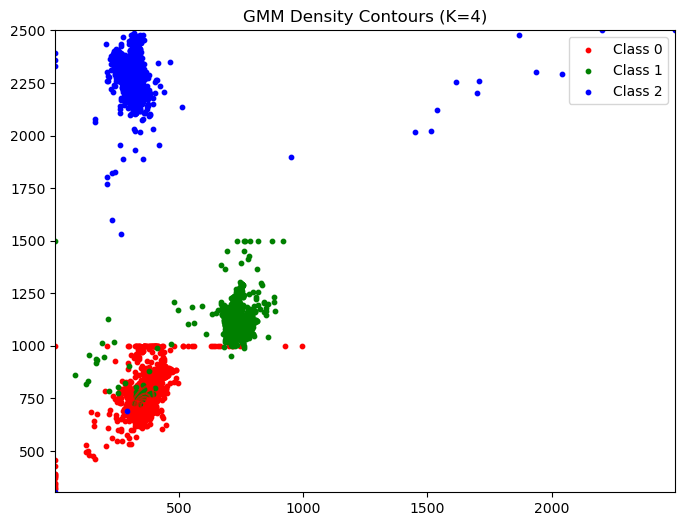

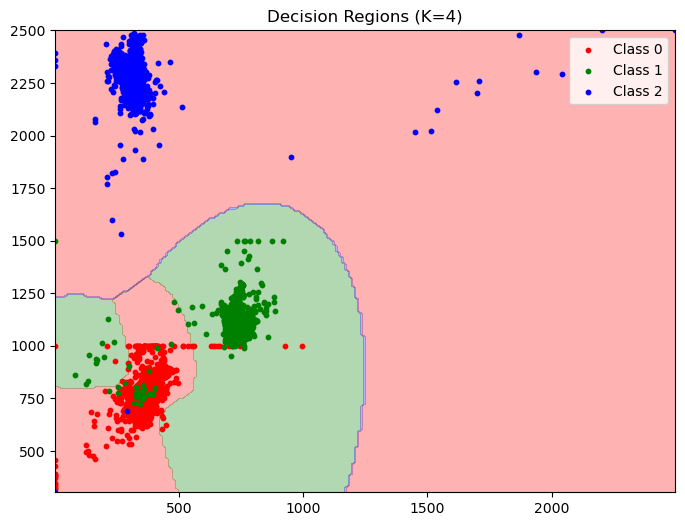

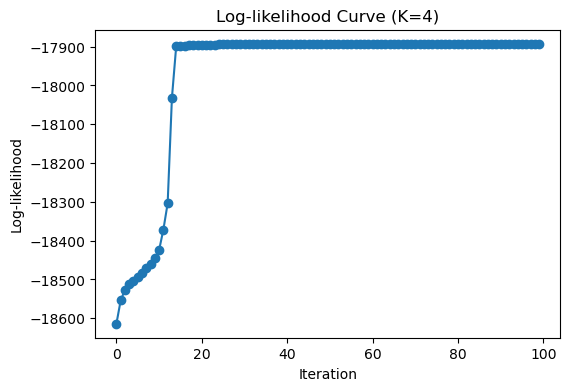

C:\Users\Pratik Manusmare\AppData\Local\Temp\ipykernel_5224\2022378541.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Zc, levels=levels, colors=colors[i], alpha=0.9, linewidths=2, linestyles='solid', label=f'GMM Class {i}')


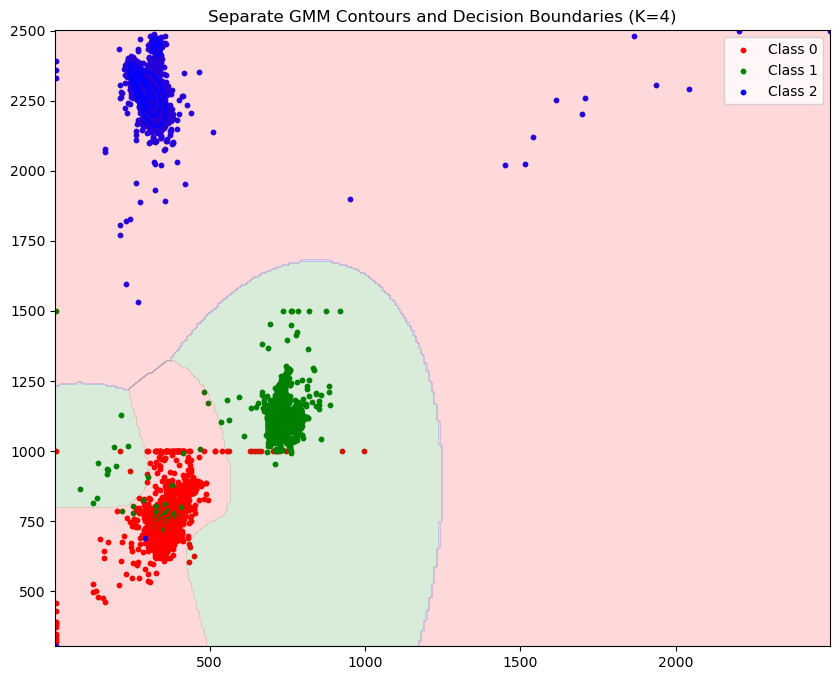

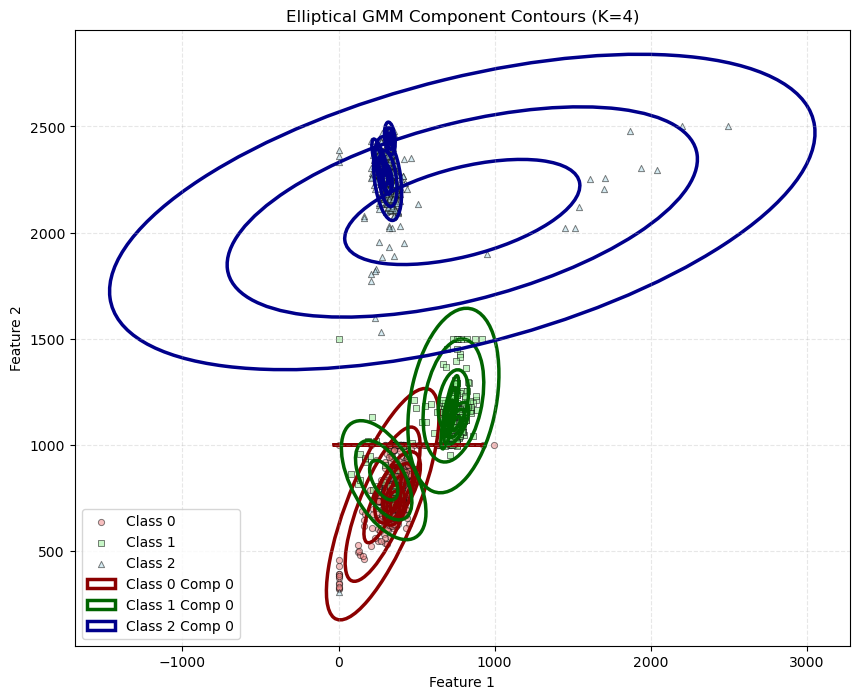

Accuracy: 0.9910
Precision per class: ['0.9765', '1.0000', '0.9986']
Mean Precision: 0.9917
Recall per class: ['1.0000', '0.9723', '0.9986']
Mean Recall: 0.9903
F1 per class: ['0.9881', '0.9860', '0.9986']
Mean F1: 0.9909
Confusion Matrix:
[[747   0   0]
 [ 17 632   1]
 [  1   0 716]]


In [22]:
if __name__ == "__main__":
    K = 4
    result_dir = 'results/Dataset2a_Speech'
    train2a, test2a = load_txt_data(
        r'd:\IITDH\Sem1\SPRL\SPR_Assignment\SPR\Dataset\Group04\rd_group4',
        ['class1', 'class2', 'class3']
    )
    run_experiment('Dataset2a_Speech', train2a, test2a, [1,2,4,], result_dir)

    # Load results for a given K
    gmm_params_list = [load_npy(f'{result_dir}/gmm_params_class{i}_K{K}.npy').item() for i in range(3)]
    log_likelihoods = load_npy(f'{result_dir}/gmm_loglik_class0_K{K}.npy')
    metrics = load_json(f'{result_dir}/metrics_K{K}.json')

    # Visualization
    plot_gmm_contours(train2a, gmm_params_list, K, save_path=f'{result_dir}/gmm_contours_K{K}.png')
    plot_decision_regions(train2a, gmm_params_list, K, save_path=f'{result_dir}/decision_regions_K{K}.png')
    plot_log_likelihood(log_likelihoods, K, save_path=f'{result_dir}/loglik_K{K}.png')
    plot_gmm_contours_with_decision_separate(train2a, gmm_params_list, K, save_path=f'{result_dir}/gmm_contours_decision_separate_K{K}.png')
    plot_gmm_elliptical_contours(train2a, gmm_params_list, K, save_path=f'{result_dir}/gmm_elliptical_contours_K{K}.png')

    # Print metrics
    print_metrics(metrics)